# Практическая работа №4 
# Генеративно-состязательные сети (GAN): Генерация изображений на примере CIFAR-10

## Цели и задачи

### Цель работы: 
Изучить принципы работы генеративно-состязательных сетей (GAN) на примере задачи генерации изображений из датасета CIFAR-10. Сравнить производительность двух архитектур: обычного GAN и DCGAN (Deep Convolutional GAN).

### Задачи:
1. Изучить библиотеки для работы с GAN (например, TensorFlow/Keras или PyTorch).
2. Загрузить и предобработать датасет CIFAR-10.
3. Разделить данные на обучающую и тестовую выборки.
4. Реализовать две архитектуры:
   - Обычный GAN (полносвязные слои).
   - DCGAN (свёрточные слои).
5. Обучить модели на обучающей выборке.
6. Оценить качество моделей на тестовой выборке.
7. Сравнить результаты генерации изображений между обычным GAN и DCGAN.
8. Визуализировать результаты обучения и оценки качества моделей.


# Загрузка данных


## Загрузка библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import utils
import numpy as np




# Устройство (GPU при наличии)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:

# Параметры
batch_size = 64
z_dim = 150     # размер вектора шума
num_epochs = 50

# Загрузка данных CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация в диапазон [-1, 1]
])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print('done!')

100%|██████████| 170M/170M [00:01<00:00, 98.9MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
done!


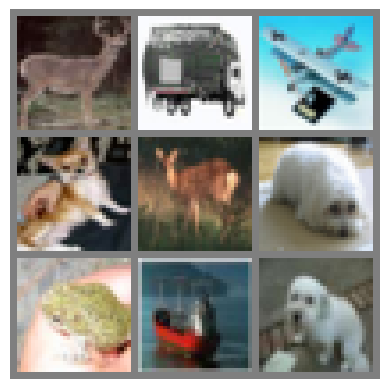

In [3]:
from torch.utils.data import DataLoader
from torchvision import utils
import numpy as np
# Функция для визуализации изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация к диапазону [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


dataiter = iter(dataloader_train)
images, labels = next(dataiter)
imshow(utils.make_grid(images[:9], nrow=3))


# GAN

In [4]:

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, img_size=32):
        super().__init__()
        self.img_size = img_size
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_channels * img_size * img_size),
            nn.Tanh(),  # выход в диапазоне [-1, 1]
        )

    def forward(self, x):
        return self.gen(x).view(-1, 3, self.img_size, self.img_size)


class Discriminator(nn.Module):
    def __init__(self, img_channels=3, img_size=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_channels * img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),  # выход 0..1 (вероятность подлинности)
        )

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        return self.disc(x)


# Создаём экземпляры сети
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# Функция потерь и оптимизаторы
criterion = nn.BCELoss()  # бинарная кроссэнтропия
lr = 0.0002
opt_gen = optim.Adam(gen.parameters(), lr=lr)
opt_disc = optim.Adam(disc.parameters(), lr=lr)

print('done!')


done!


## Обучение GAN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Функция для обучения GAN
def train_gan(gen, disc, dataloader_train, num_epochs, z_dim, device):
    # Функция потерь и оптимизаторы
    criterion = nn.BCELoss()  # бинарная кроссэнтропия
    lr = 0.0002
    opt_gen = optim.Adam(gen.parameters(), lr=lr)
    opt_disc = optim.Adam(disc.parameters(), lr=lr)

    # Списки для хранения потерь
    discriminator_losses = []  # Потери дискриминатора
    generator_losses = []  # Потери генератора

    # Обучение
    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(dataloader_train):
            real = real.to(device)
            batch_size_curr = real.shape[0]

            # ============ Тренируем дискриминатор ============
            # Шум -> фейковые картинки
            noise = torch.randn(batch_size_curr, z_dim).to(device)
            fake = gen(noise)

            # Вычисляем вероятность для реальных и фейковых
            disc_real = disc(real).view(-1)
            disc_fake = disc(fake.detach()).view(-1)

            # Метки (1 - настоящие, 0 - фейк)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2

            disc.zero_grad()
            lossD.backward()
            opt_disc.step()

            # ============ Тренируем генератор ============
            # Новые фейковые картинки, оцениваем дискриминатором
            output = disc(fake).view(-1)
            lossG = criterion(output, torch.ones_like(output))  # хотим, чтобы дискрим. сказал 1

            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

            # Сохраняем потери
            discriminator_losses.append(lossD.item())
            generator_losses.append(lossG.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

    return discriminator_losses, generator_losses


# Создаём экземпляры сети
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# Запуск обучения
discriminator_losses, generator_losses = train_gan(gen, disc, dataloader_train, num_epochs, z_dim, device)

Epoch [1/50] | Loss D: 0.1890, Loss G: 2.3184
Epoch [2/50] | Loss D: 0.5470, Loss G: 3.2263
Epoch [3/50] | Loss D: 0.1193, Loss G: 3.9757
Epoch [4/50] | Loss D: 0.2648, Loss G: 3.0570
Epoch [5/50] | Loss D: 0.2127, Loss G: 3.9046
Epoch [6/50] | Loss D: 0.2069, Loss G: 3.2587
Epoch [7/50] | Loss D: 0.2855, Loss G: 2.0859
Epoch [8/50] | Loss D: 0.4804, Loss G: 2.2018
Epoch [9/50] | Loss D: 0.5538, Loss G: 1.4342
Epoch [10/50] | Loss D: 0.6812, Loss G: 1.5389
Epoch [11/50] | Loss D: 0.4469, Loss G: 1.6918
Epoch [12/50] | Loss D: 0.3827, Loss G: 2.0714
Epoch [13/50] | Loss D: 0.6337, Loss G: 1.7415
Epoch [14/50] | Loss D: 0.3890, Loss G: 1.6603
Epoch [15/50] | Loss D: 0.3857, Loss G: 1.5863
Epoch [16/50] | Loss D: 0.3587, Loss G: 1.7504
Epoch [17/50] | Loss D: 0.5698, Loss G: 1.4749
Epoch [18/50] | Loss D: 0.5872, Loss G: 1.2389
Epoch [19/50] | Loss D: 0.4277, Loss G: 1.7803
Epoch [20/50] | Loss D: 0.5684, Loss G: 1.5082
Epoch [21/50] | Loss D: 0.4616, Loss G: 1.6338
Epoch [22/50] | Loss D

# Метрики GAN

## Визуализируем данные

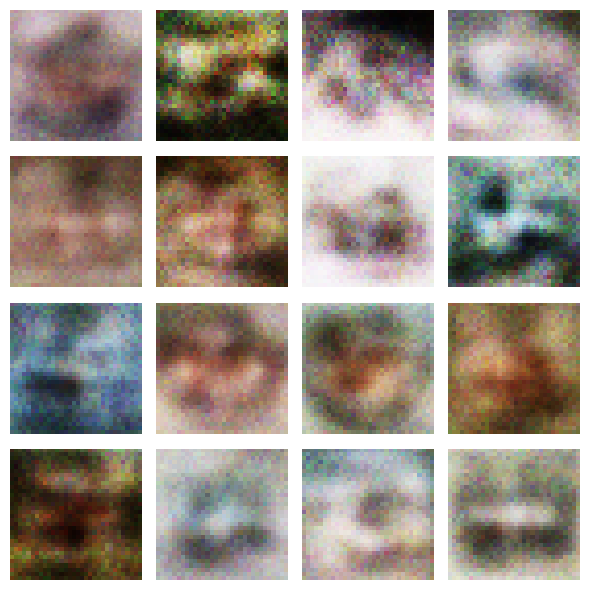

In [6]:

# Проверка генерации: берём шум и смотрим, что получится
gen.eval()
with torch.no_grad():
    sample_noise = torch.randn(16, z_dim).to(device)
    generated = gen(sample_noise).cpu()
    generated = (generated + 1) / 2  # денормализация из [-1,1] в [0,1]

# Отобразим 16 сгенерированных изображений
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated[i].permute(1, 2, 0))  # Перестановка осей для отображения
    ax.axis('off')
plt.tight_layout()
plt.show()

## Отобразим графики потерь

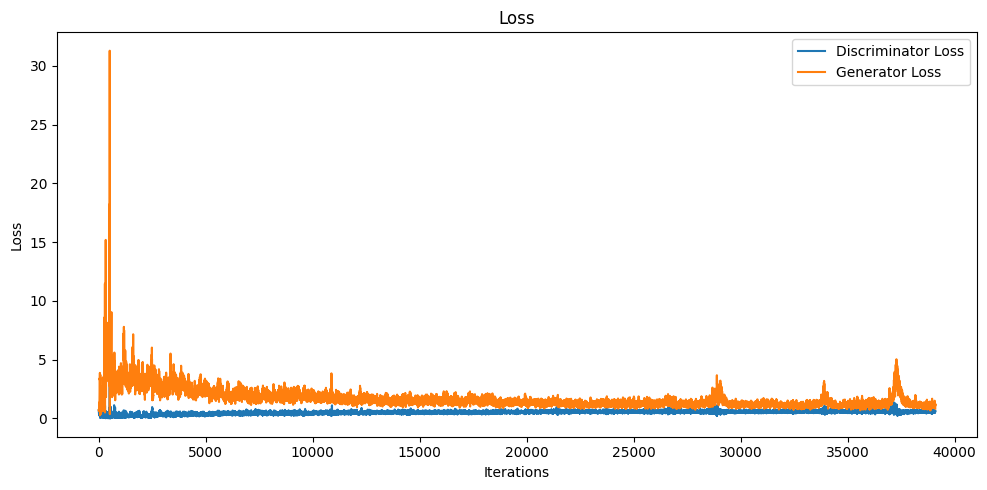

In [7]:
# Функция для построения графиков потерьplot_losses(discriminator_losses, generator_losses):
plt.figure(figsize=(10, 5))
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# DCGAN

In [16]:
from torchmetrics.image.inception import InceptionScore

# Устройство (GPU при наличии)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Параметры
batch_size = 64
z_dim = 1  # Размерность вектора шума
num_epochs = 50  # Количество эпох
nc = 3  # Количество каналов в изображении (RGB)
ndf = 64  # Количество фильтров в дискриминаторе
ngf = 64  # Количество фильтров в генераторе
lr = 0.0002  # Скорость обучения
beta1 = 0.5  # Параметр для оптимизатора Adam

# Загрузка набора данных CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация в диапазон [-1, 1]
])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)




Using device: cuda
Files already downloaded and verified


In [17]:
# Определение генератора
class Generator_DCGAN(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator_DCGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 32 x 32``
        )

    def forward(self, input):
        return self.main(input)



# Определение дискриминатора
class Discriminator_DCGAN(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator_DCGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 32 x 32``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 16 x 16``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 8 x 8``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 4 x 4``
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [18]:

# Функция для обучения
def train(gen, disc, dataloader, num_epochs, device):
    # Функция потерь и оптимизаторы
    criterion = nn.BCELoss()
    opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

    # Списки для хранения потерь
    lossD_list = []
    lossG_list = []

    # Обучение
    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(dataloader):
            real = real.to(device)
            batch_size_curr = real.shape[0]

            # ============ Тренируем дискриминатор ============
            # Шум -> фейковые картинки
            noise = torch.randn(batch_size_curr, z_dim, 1, 1).to(device)
            fake = gen(noise)

            # Вычисляем вероятность для реальных и фейковых
            disc_real = disc(real).view(-1)
            disc_fake = disc(fake.detach()).view(-1)

            # Метки (1 - настоящие, 0 - фейк)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2

            disc.zero_grad()
            lossD.backward()
            opt_disc.step()

            # ============ Тренируем генератор ============
            # Новые фейковые картинки, оцениваем дискриминатором
            output = disc(fake).view(-1)
            lossG = criterion(output, torch.ones_like(output))  # хотим, чтобы дискрим. сказал 1

            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

            # Сохраняем потери
            lossD_list.append(lossD.item())
            lossG_list.append(lossG.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

    return lossD_list, lossG_list

# Создание моделей
gen = Generator_DCGAN().to(device)
disc = Discriminator_DCGAN().to(device)

# Обучение модели
lossD_list, lossG_list = train(gen, disc, dataloader_train, num_epochs, device)



Epoch [1/50] | Loss D: 0.2485, Loss G: 3.0411
Epoch [2/50] | Loss D: 0.1287, Loss G: 3.9076
Epoch [3/50] | Loss D: 0.1067, Loss G: 4.7820
Epoch [4/50] | Loss D: 0.1002, Loss G: 3.4502
Epoch [5/50] | Loss D: 0.0491, Loss G: 5.8142
Epoch [6/50] | Loss D: 0.0424, Loss G: 7.7972
Epoch [7/50] | Loss D: 0.1287, Loss G: 3.8486
Epoch [8/50] | Loss D: 0.1633, Loss G: 4.9964
Epoch [9/50] | Loss D: 0.2787, Loss G: 3.2303
Epoch [10/50] | Loss D: 0.1406, Loss G: 8.4344
Epoch [11/50] | Loss D: 0.0503, Loss G: 7.0198
Epoch [12/50] | Loss D: 0.2145, Loss G: 9.9315
Epoch [13/50] | Loss D: 0.3560, Loss G: 2.8756
Epoch [14/50] | Loss D: 0.1633, Loss G: 3.0555
Epoch [15/50] | Loss D: 0.0883, Loss G: 3.5113
Epoch [16/50] | Loss D: 0.0006, Loss G: 14.5187
Epoch [17/50] | Loss D: 0.1400, Loss G: 5.0569
Epoch [18/50] | Loss D: 0.1572, Loss G: 5.1662
Epoch [19/50] | Loss D: 0.1549, Loss G: 6.5466
Epoch [20/50] | Loss D: 0.0307, Loss G: 7.4931
Epoch [21/50] | Loss D: 0.0301, Loss G: 7.5206
Epoch [22/50] | Loss 

# Метрики GAN

## Визуализируем данные

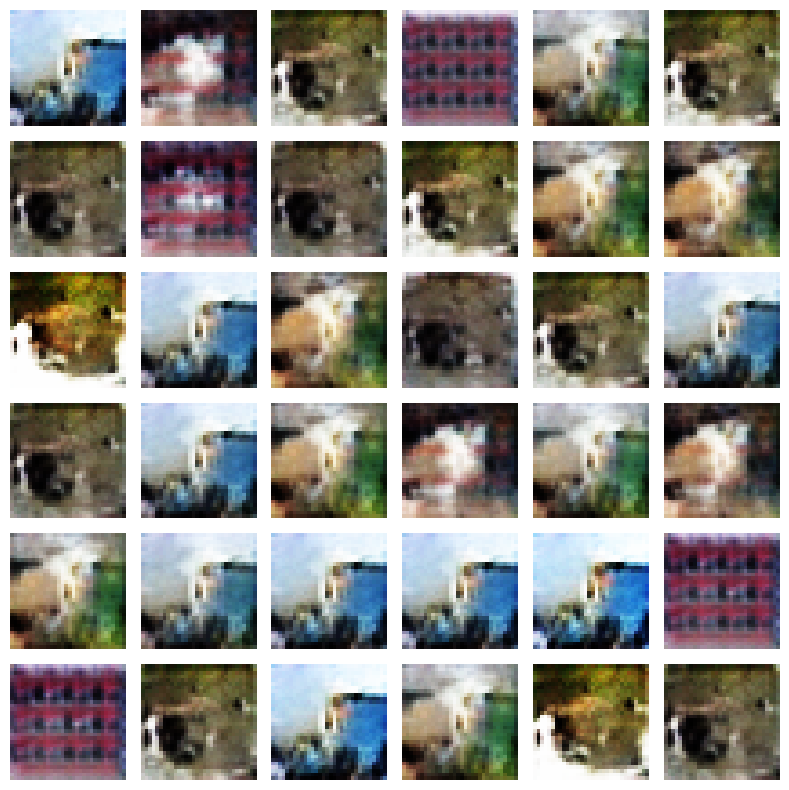

In [24]:

with torch.no_grad():
    fake_images = gen(torch.randn(36, z_dim, 1, 1).to(device)).cpu()
    fake_images = (fake_images + 1) / 2  # Денормализация
    fake_images = fake_images.permute(0, 2, 3, 1)

    fig, axes = plt.subplots(6, 6, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# # Оценка качества сгенерированных изображений с помощью InceptionScore
# if (epoch + 1) % 5 == 0:
#     with torch.no_grad():
#         fake_images = gen(torch.randn(64, z_dim, 1, 1).to(device))
#         fake_images = (fake_images + 1) / 2  # Денормализация
#         inception_score.update(fake_images)
    #         print(f"Inception Score: {inception_score.compute()}")

## Отобразим графики потерь

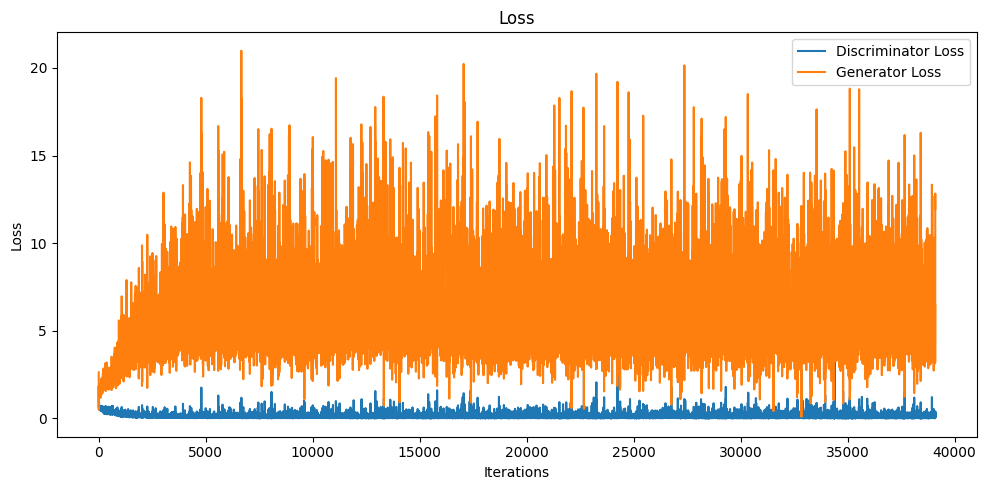

In [22]:
# Вывод графиков потерь
plt.figure(figsize=(10, 5))
plt.plot(lossD_list, label='Discriminator Loss')
plt.plot(lossG_list, label='Generator Loss')
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Денормализация изображений
def denormalization(x):
    return x * 0.5 + 0.5

# Функция для генерации шума
def noise_gen(batch_size, nz=100):
    return torch.randn(batch_size, nz)

In [ ]:
from IPython.display import clear_output

!pip install -q --upgrade diffusers transformers accelerate
!pip install -q torchmetrics[image]
!pip install -q lightning tbparse
!pip install torch-fidelity

clear_output()

print('done!')

done!


In [ ]:
import lightning as L
import torch
import torchvision
from torchvision import utils
from torchmetrics import MetricCollection
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
import matplotlib.pyplot as plt

def noise_gen(batch_size, nz=100):
    return torch.randn(batch_size, nz)

class RunMetric(L.LightningModule):
    def __init__(self, generator, noise_gen, detransform):
        super().__init__()  # Исправлено: super().__init__() без аргументов
        # model
        self.generator = generator
        self.noise_gen = noise_gen
        self.detransform = detransform

        # metrics
        self.is_real = InceptionScore()
        self.is_fake = InceptionScore()

        self.fid = MetricCollection(
            {
                "FIR_64": FrechetInceptionDistance(feature=64),
                "FIR_192": FrechetInceptionDistance(feature=192),
                "FIR_768": FrechetInceptionDistance(feature=768),
                "FIR_2048": FrechetInceptionDistance(feature=2048),
            }
        )

    def test_step(self, batch, batch_idx):
        real, _ = batch
        batch_size = real.shape[0]
        noise = self.noise_gen(batch_size).to(self.device)
        fake = self.generator(noise)
        fake = self.detransform(fake)

        real = (real * 255).type(torch.uint8)
        fake = (fake * 255).type(torch.uint8)

        self.fake = fake

        self.is_real.update(real)
        self.is_fake.update(fake)

        self.fid.update(real, real=True)
        self.fid.update(fake, real=False)

    def on_test_epoch_end(self):
        is_real = self.is_real.compute()[0]
        self.log("IS_real", is_real.item())
        self.is_real.reset()

        is_fake = self.is_fake.compute()[0]
        self.log("IS_fake", is_fake.item())
        self.is_fake.reset()

        fid = self.fid.compute()
        self.log_dict(fid)
        self.fid.reset()

        fig, ax = plt.subplots(figsize=(16 * 3, 2 * 3))
        ax.imshow(
            torchvision.utils.make_grid(self.fake).permute(1, 2, 0).cpu().numpy(),
            interpolation="nearest",
            aspect="equal",
        )
        ax.axis("off")
        plt.show()

# Создание экземпляра модели
pl_model = RunMetric(gen, noise_gen, denormalization)

# Очистка вывода (если используется в Jupyter Notebook)
from IPython.display import clear_output
clear_output()

# Запуск тестирования
trainer = L.Trainer(max_epochs=0)
metrics = trainer.test(model=pl_model, dataloaders=test_loader)

ModuleNotFoundError: InceptionScore metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.